In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [82]:
# load raw data
data = pd.read_stata('data/dataset.dta')
data_2 = pd.read_stata('data/dataset.dta')
data.vote_trump = data.vote_trump.cat.add_categories(['Unknow']).fillna('Unknow')

In [67]:
# list columns
data.columns.unique

<bound method Index.unique of Index(['id', 'weight', 'state', 'dist', 'pres_economy', 'dem_party',
       'rep_party', 'hhold_size', 'current_economy', 'buy_guns',
       'important_english', 'syrian', 'global_warming', 'abortion', 'age',
       'number_children', 'length_community', 'dem_candidate', 'rep_candidate',
       'feminists', 'liberals', 'conservatives', 'gays', 'muslims',
       'christians', 'jews', 'trans', 'scientists', 'black_lives',
       'vaccine_school', 'immigrant_level', 'vaccine_risk', 'marijuana',
       'imm_harm', 'align_democrat', 'hispanics', 'blacks', 'illegal_imm',
       'whites', 'vote_trump', 'distrust', 'corrupt', 'wrong_track',
       'support_wall', 'deny_syrians', 'minority_adapt', 'imm_level_high',
       'authority', 'ei', 'ei_lag', 'union', 'insurance', 'inequal',
       'worry_finances', 'ur_dist', 'poor_economy', 'since_08', 'last_yr',
       'next_yr', 'dem_economy', 'rep_economy', 'rep_id', 'dem_id', 'ind_id',
       'male', 'less_hs', 'hs', 

In [4]:
# trump voter income levels
data_income = data[['id', 'vote_trump', 'income', 'worry_finances']]

In [5]:
# drop income == 1 rows
data_income = data_income.loc[data_income.income != 0].dropna()

In [6]:
data_income.vote_trump.value_counts()

No        1297
Yes       1025
Unknow     800
Name: vote_trump, dtype: int64

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


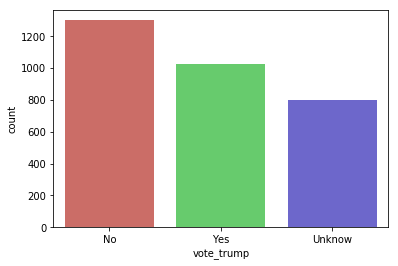

In [7]:
sns.countplot(x='vote_trump', data=data_income, palette='hls')

In [8]:
data_income.groupby('vote_trump').mean()

,id,income
vote_trump,,
No,374877.87500,87196.234375
Yes,376291.78125,82576.718750
Unknow,376015.43750,66147.007812


In [9]:
data_income.groupby('worry_finances').mean()

,id,income
worry_finances,,
Not at all worried,363782.31250,104896.773438
A little worried,374507.46875,91736.101562
Moderately worried,379372.56250,72586.882812
Very worried,383095.31250,54695.074219
Extremely worried,380203.31250,55817.843750


In [10]:
finance_count = data_income.worry_finances.value_counts()

In [11]:
finance_vote_count = data_income.loc[data_income.vote_trump == 'Yes'].worry_finances.value_counts()

In [12]:
finace_vote_df = pd.DataFrame(
    data = {
        'finance_count' : finance_count,
        'finance_vote_count' : finance_vote_count,
        'finance_vote_rate' : np.round((finance_vote_count / finance_count) * 100, 2)
    }
)

In [13]:
finace_vote_df

,finance_count,finance_vote_count,finance_vote_rate
Not at all worried,565,182,32.21
A little worried,927,325,35.06
Moderately worried,941,317,33.69
Very worried,371,105,28.30
Extremely worried,318,96,30.19


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

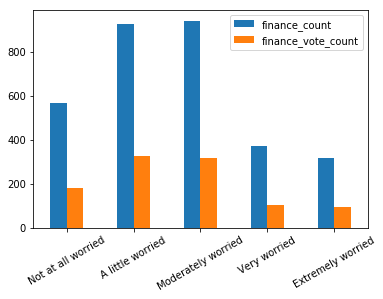

In [14]:
finace_vote_df[['finance_count', 'finance_vote_count']].plot.bar()
plt.xticks(rotation=30)

# Trump voter with age

In [15]:
data_age = data[['id', 'vote_trump', 'age']].dropna()

In [16]:
# replace 90. Age 90 or older to 90
data_age.age = data_age.age.replace('90. Age 90 or older', 90)

In [17]:
# vote trump distribution
vote_age = data_age.loc[data_age.vote_trump == 'Yes']
vote_age_df = vote_age.groupby('age').count().rename(columns={"vote_trump": "Vote"})

In [18]:
# select not vote trump
not_vote_age = data_age.loc[data_age.vote_trump == 'No']
not_vote_age = not_vote_age.groupby('age').count().rename(columns={"vote_trump": "Not_Vote"})

In [19]:
#select unknow vote
unknown_vote_age = data_age.loc[data_age.vote_trump == 'Unknow'].groupby('age').count().rename(columns={'vote_trump': 'Unknow'})

In [20]:
df_vote = vote_age_df.merge(not_vote_age, left_index=True, right_index=True)
df_vote = df_vote.merge(unknown_vote_age, left_index=True, right_index=True).drop(columns=['id_x', 'id_y', 'id'])

In [21]:
df_vote['Not&Unknow'] = df_vote['Not_Vote'] + df_vote.Unknow
df_vote['num'] = df_vote['Not&Unknow'] + df_vote['Vote']
df_vote['vote_rate'] = np.round(df_vote['Vote'] / df_vote['num'] * 100, 2)

In [22]:
df_vote = df_vote.reset_index()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


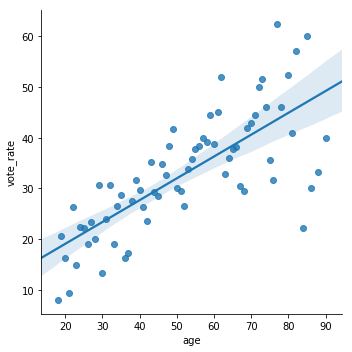

In [23]:
sns.lmplot(x='age', y='vote_rate', data=df_vote, fit_reg=True)

In [24]:
age_vote_model = smf.ols(formula='vote_rate ~  age', data=df_vote).fit()
print(age_vote_model.summary())

                            OLS Regression Results                            
Dep. Variable:              vote_rate   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     87.36
Date:                Mon, 02 Dec 2019   Prob (F-statistic):           9.19e-14
Time:                        20:09:14   Log-Likelihood:                -238.33
No. Observations:                  69   AIC:                             480.7
Df Residuals:                      67   BIC:                             485.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4633      2.582      4.053      0.0

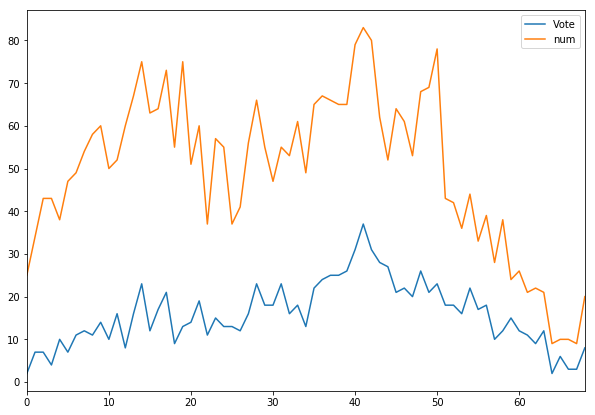

In [25]:
df_vote[['Vote', 'num']].plot(figsize=(10, 7))

# age Vs income

In [26]:
# merge income & age
df_income_age = data_income.merge(data_age, on='id', how='outer').drop(columns=['vote_trump_y']).dropna()

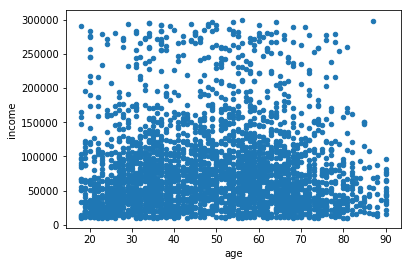

In [27]:
df_income_age.plot(kind='scatter', x='age', y='income')

In [28]:
df_income_age.groupby('worry_finances').mean()

,id,income,age
worry_finances,,,
Not at all worried,363204.355072,105219.968750,51.085145
A little worried,374443.551043,91420.578125,49.182217
Moderately worried,379274.600646,72556.125000,49.103337
Very worried,383445.065395,54933.105469,46.975477
Extremely worried,380203.298742,55817.843750,47.367925


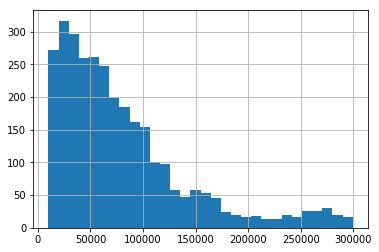

In [29]:
df_income_age.income.hist(bins=30)

In [30]:
df_income_age_vote = df_income_age.loc[df_income_age.vote_trump_x == 'Yes'].drop(columns=['id'])

In [31]:
df_income_age_not_vote = df_income_age.loc[df_income_age.vote_trump_x == 'No'].drop(columns=['id'])

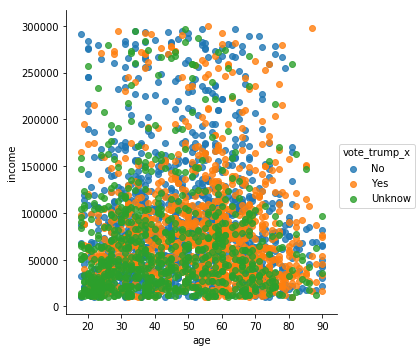

In [32]:
sns.lmplot(x='age', y='income', data=df_income_age, fit_reg=False, hue='vote_trump_x')

In [33]:
df_income_age.income.min()

10002.0

In [34]:
df_income_age.income.max()

299378.0

In [35]:
df_income_age['income_level'] = pd.cut(df_income_age.income, np.arange(10000, 301000, 20000))

In [36]:
income_vote = df_income_age.loc[df_income_age.vote_trump_x == 'Yes'].groupby('income_level').count()
income_count = df_income_age.groupby('income_level').count()

In [37]:
df_income_level = income_vote.merge(income_count, left_index=True, right_index=True)

In [38]:
df_income_level = df_income_level.drop(columns=['id_x', 'income_x', 'worry_finances_x', 'age_x', 'id_y'])
df_income_level = df_income_level.drop(columns=['income_y', 'worry_finances_y', 'age_y'])

In [39]:
df_income_level = df_income_level.rename(columns={"vote_trump_x_x": "vote_trump", 'vote_trump_x_y': 'vote_total'})

In [40]:
df_income_level['vote%'] = np.round((df_income_level.vote_trump / df_income_level.vote_total) * 100, 2)

In [41]:
df_income_level = df_income_level.reset_index()

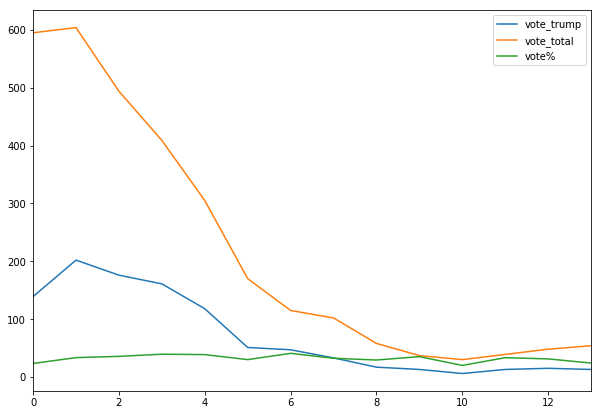

In [42]:
df_income_level.plot(figsize=(10, 7))

# trump voter VS house size

In [43]:
data_house = data[['vote_trump', 'hhold_size']]

In [44]:
# replace hhold_size 9 10 11 12 13 to 9
data_house = data_house.replace([10, 11, 12, 13], 9)

In [45]:
data_house_count = data_house.groupby('hhold_size').count().reset_index().rename(columns={'vote_trump': 'vote'})

In [46]:
data_house_vote = data_house.loc[data_house.vote_trump == 'Yes'].groupby('hhold_size').count().reset_index()

In [47]:
data_house_vote = data_house_vote.merge(data_house_count, on='hhold_size')

In [48]:
data_house_vote['vote_rate'] = np.round((data_house_vote.vote_trump / data_house_vote.vote) * 100, 2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


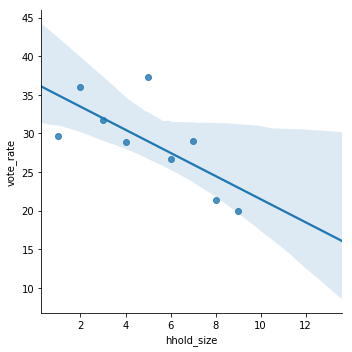

In [49]:
sns.lmplot(x='hhold_size', y='vote_rate', data=data_house_vote, fit_reg=True)

In [50]:
house_mod = smf.ols(formula='vote_rate ~ hhold_size', data=data_house_vote).fit()
print(house_mod.summary())

                            OLS Regression Results                            
Dep. Variable:              vote_rate   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     6.972
Date:                Mon, 02 Dec 2019   Prob (F-statistic):             0.0334
Time:                        20:09:50   Log-Likelihood:                -24.969
No. Observations:                   9   AIC:                             53.94
Df Residuals:                       7   BIC:                             54.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4706      3.195     11.416      0.0

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


# relationship household size VS age

In [51]:
data_house_age = data[['hhold_size', 'age']].dropna()
data_house_age = data_house_age.replace('90. Age 90 or older', 90)
data_house_age = data_house_age.replace([10, 11, 12, 13], 9)

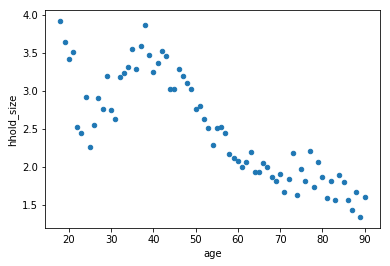

In [52]:
data_house_age.groupby('age').mean().reset_index().plot.scatter(x='age', y='hhold_size')

# vote rate with Children number

In [53]:
child_df = data[['vote_trump', 'number_children', 'children']]

In [54]:
# set dummy variables 
child_df['vote_cat'] = [1 if x == 'Yes' else 0 for x in child_df.vote_trump]
child_df['child_cat'] = [1 if x == 'Yes' else 0 for x in child_df.children]
child_df['child_num'] = child_df.number_children.apply(lambda x: int(x[0]))
child_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,vote_trump,number_children,children,vote_cat,child_cat,child_num
0,Yes,1. One child,Yes,1,1,1
1,Yes,0. No children,No,1,0,0
2,Unknow,2. Two children,Yes,0,1,2
3,Unknow,0. No children,No,0,0,0
4,No,3. Three children,Yes,0,1,3


In [55]:
child_mod = smf.ols(formula='vote_cat ~ C(child_cat) + child_num', data=child_df).fit()

In [56]:
child_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vote_cat   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.651
Date:                Mon, 02 Dec 2019   Prob (F-statistic):            0.00354
Time:                        20:10:02   Log-Likelihood:                -2322.3
No. Observations:                3532   AIC:                             4651.
Df Residuals:                    3529   BIC:                             4669.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3415      0.010     35.491      0.000       0.323       0.360
C(child_cat)[T.1]    -0.0731      0.030     -2.440      0.015      -0.132      -0.014
child_num             0.0099      0.013      0.737      0.461      -0.016       0.036
==============================================================================
Omnibus:                      267.815   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              629.550
Skew:                           0.751   Prob(JB):                    1.97e-137
Kurtosis:                       1.579   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# party VS vote

In [84]:
data_dem = data_2[['vote_trump','dem_party']].dropna()
data_dem.head()

,vote_trump,dem_party
0,Yes,0.0
1,Yes,15.0
4,No,70.0
5,No,85.0
6,Yes,0.0


In [97]:
dem_data = data_dem.groupby('dem_party').count().reset_index()

In [98]:
dem_vote = data_dem.loc[data_dem.vote_trump == 'Yes'].groupby('dem_party').count().reset_index()

In [99]:
dem_data = dem_data.merge(dem_vote, on='dem_party', how='left').rename(columns={"vote_trump_x": 'dem', 'vote_trump_y': 'vote'})

In [101]:
dem_data['vote_rate'] = np.round((dem_data.vote / dem_data.dem)*100, 2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


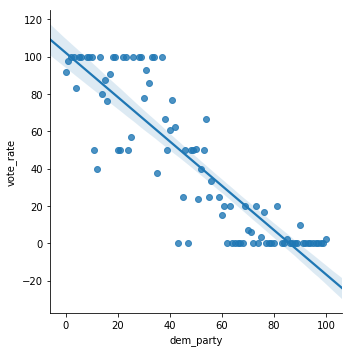

In [112]:
sns.lmplot(x='dem_party', y='vote_rate', data=dem_data, fit_reg=True)

In [113]:
dem_mod = smf.ols(formula='vote_rate ~ dem_party', data=dem_data).fit()
dem_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vote_rate   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     320.6
Date:                Mon, 02 Dec 2019   Prob (F-statistic):           9.78e-32
Time:                        21:22:06   Log-Likelihood:                -409.18
No. Observations:                  94   AIC:                             822.4
Df Residuals:                      92   BIC:                             827.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.0687      3.877     26.328      0.000      94.369     109.768
dem_party     -1.1879      0.066    -17.906      0.000      -1.320      -1.056
==============================================================================
Omnibus:                        1.913   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                1.471
Skew:                          -0.298   Prob(JB):                        0.479
Kurtosis:                       3.139   Cond. No.                         116.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
# rep_party
rep_data = data_2[['vote_trump', 'rep_party']].dropna()
rep_data.head()

,vote_trump,rep_party
0,Yes,70.0
1,Yes,85.0
4,No,40.0
5,No,15.0
6,Yes,40.0


In [120]:
rep_party = rep_data.groupby('rep_party').count().reset_index()

In [121]:
rep_vote = rep_data.loc[rep_data.vote_trump == 'Yes'].groupby('rep_party').count().reset_index()

In [122]:
rep_party_rate = rep_party.merge(rep_vote, on='rep_party', how='left')

In [126]:
rep_party_rate = rep_party_rate.rename(columns={'vote_trump_x': 'rep', 'vote_trump_y': 'vote'})
rep_party_rate['vote_rate'] = np.round((rep_party_rate.vote / rep_party_rate.rep)*100, 2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


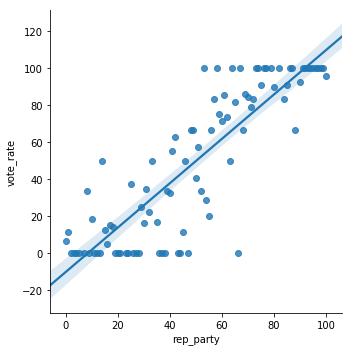

In [128]:
sns.lmplot(x='rep_party', y='vote_rate', data=rep_party_rate, fit_reg=True)

In [129]:
rep_mod = smf.ols(formula='vote_rate ~ rep_party', data=rep_party_rate).fit()
rep_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vote_rate   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     267.1
Date:                Mon, 02 Dec 2019   Prob (F-statistic):           6.01e-29
Time:                        21:32:08   Log-Likelihood:                -416.59
No. Observations:                  94   AIC:                             837.2
Df Residuals:                      92   BIC:                             842.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.2665      4.210     -2.439      0.017     -18.628      -1.905
rep_party      1.1995      0.073     16.342      0.000       1.054       1.345
==============================================================================
Omnibus:                        6.237   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.729
Skew:                          -0.488   Prob(JB):                       0.0570
Kurtosis:                       3.715   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
#dem_candidate		Feeling thermometer: Clinton [0-100]
clinton_data = data_2[['vote_trump', 'dem_candidate']].dropna()
clinton_data.head()

,vote_trump,dem_candidate
0,Yes,15.0
1,Yes,50.0
4,No,30.0
5,No,85.0
6,Yes,15.0


In [133]:
clinton = clinton_data.groupby('dem_candidate').count().reset_index()

In [134]:
clinton_vote = clinton_data.loc[clinton_data.vote_trump == 'Yes'].groupby('dem_candidate').count().reset_index()

In [136]:
clinton_vote = clinton.merge(clinton_vote, on='dem_candidate', how='left')

In [140]:
clinton_vote = clinton_vote.rename(columns={'vote_trump_x': 'cliton', 'vote_trump_y': 'vote'})
clinton_vote['vote_rate'] = np.round((clinton_vote.vote / clinton_vote.cliton)*100, 2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


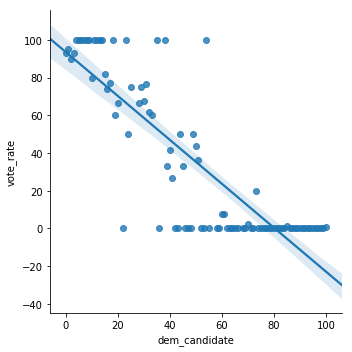

In [141]:
sns.lmplot(x='dem_candidate', y='vote_rate', data=clinton_vote, fit_reg=True)

In [142]:
cliton_mod = smf.ols(formula='vote_rate ~ dem_candidate', data=clinton_vote).fit()
cliton_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vote_rate   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     235.1
Date:                Mon, 02 Dec 2019   Prob (F-statistic):           5.88e-27
Time:                        21:41:05   Log-Likelihood:                -418.06
No. Observations:                  93   AIC:                             840.1
Df Residuals:                      91   BIC:                             845.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        93.6383      4.482     20.890      0.000      84.735     102.542
dem_candidate    -1.1660      0.076    -15.333      0.000      -1.317      -1.015
==============================================================================
Omnibus:                        5.507   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                6.769
Skew:                          -0.243   Prob(JB):                       0.0339
Kurtosis:                       4.229   Cond. No.                         116.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
# rep_candidate
trump_data = data_2[['vote_trump', 'rep_candidate']].dropna()
trump_data.head()

,vote_trump,rep_candidate
0,Yes,85.0
1,Yes,60.0
4,No,15.0
5,No,50.0
6,Yes,85.0


In [145]:
trump = trump_data.groupby('rep_candidate').count().reset_index()

In [147]:
trump_vote = trump_data.loc[trump_data.vote_trump == 'Yes'].groupby('rep_candidate').count().reset_index()

In [149]:
trump_vote = trump.merge(trump_vote, on='rep_candidate', how='left')

In [151]:
trump_vote = trump_vote.rename(columns={'vote_trump_x': 'num', 'vote_trump_y': 'vote'})
trump_vote['vote_rate'] = np.round((trump_vote.vote / trump_vote.num)*100, 2)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


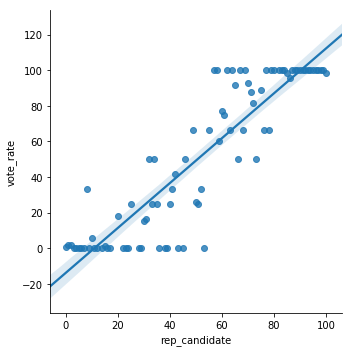

In [153]:
sns.lmplot(x='rep_candidate', y='vote_rate', data=trump_vote, fit_reg=True)

In [154]:
trump_mod = smf.ols(formula='vote_rate ~ rep_candidate', data=trump_vote).fit()
trump_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vote_rate   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     359.9
Date:                Mon, 02 Dec 2019   Prob (F-statistic):           2.69e-32
Time:                        21:50:50   Log-Likelihood:                -376.84
No. Observations:                  87   AIC:                             757.7
Df Residuals:                      85   BIC:                             762.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.8073      3.964     -3.483      0.001     -21.689      -5.925
rep_candidate     1.2604      0.066     18.971      0.000       1.128       1.392
==============================================================================
Omnibus:                        1.894   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.271
Skew:                          -0.231   Prob(JB):                        0.530
Kurtosis:                       3.370   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# multi predict on house size, age, party, party_candidate

In [165]:
# select columns we need
reg_data = data_2[['vote_trump','age','hhold_size','dem_party','rep_party','dem_candidate','rep_candidate']].dropna()

In [166]:
# clear data of age 90+
reg_data = reg_data.replace('90. Age 90 or older', 90)

In [167]:
# create dummy variable
reg_data['vote_num'] = reg_data.vote_trump.map({'Yes': 1, 'No': 0})

In [169]:
logit_reg = smf.logit(formula='vote_num ~ age + hhold_size + dem_party + rep_party + dem_candidate + rep_candidate', 
                      data=reg_data).fit()
logit_reg.summary()

Optimization terminated successfully.
         Current function value: 0.129672
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               vote_num   No. Observations:                 2480
Model:                          Logit   Df Residuals:                     2473
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Dec 2019   Pseudo R-squ.:                  0.8109
Time:                        22:04:11   Log-Likelihood:                -321.59
converged:                       True   LL-Null:                       -1701.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.6379      0.567     -4.649      0.000      -3.750      -1.526
age               0.0174      0.007      2.599      0.009       0.004       0.031
hhold_size       -0.0982      0.072     -1.357      0.175      -0.240       0.044
dem_party        -0.0340      0.006     -5.855      0.000      -0.045      -0.023
rep_party         0.0238      0.005      4.408      0.000       0.013       0.034
dem_candidate    -0.0484      0.005     -8.863      0.000      -0.059      -0.038
rep_candidate     0.0812      0.005     15.036      0.000       0.071       0.092
=================================================================================
"""

# test regresion predict accuracy

In [171]:
X_reg = reg_data[['age','hhold_size','dem_party','rep_party','dem_candidate','rep_candidate']]
y_reg = reg_data.vote_num

In [173]:
# split data for training and test
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0)
logitRegression = LogisticRegression()
logitRegression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
# make prediction on test data
y_predict = logitRegression.predict(X_test)
print('accuracy score: {:.2f}'.format(logitRegression.score(X_test, y_test)))

accuracy score: 0.96


In [175]:
# confusion matrix
confusion_matrix(y_predict, y_test)

array([[265,  14],
       [  7, 210]])

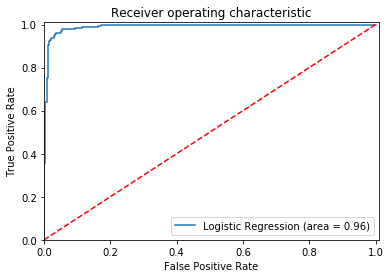

In [177]:
# print ROC curve
roc = roc_auc_score(y_test, y_predict)
fpr, tpr, threshholds = roc_curve(y_test, logitRegression.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# multi predict house size & age

In [57]:
multi_df = data[['vote_trump', 'age', 'hhold_size']].dropna()
multi_df = multi_df.replace('90. Age 90 or older', 90)
multi_df['vote_numeric'] = multi_df.vote_trump.map({'Yes': 1, 'No': 0, 'Unknow': 0})
multi_df['vote_cat'] = multi_df.vote_trump.map({'Yes': 1, 'No': -1, 'Unknow': 0})

In [58]:
multi_df

,vote_trump,age,hhold_size,vote_numeric,vote_cat
0,Yes,29.0,4.0,1,1
1,Yes,26.0,3.0,1,1
2,Unknow,23.0,3.0,0,0
3,Unknow,58.0,2.0,0,0
4,No,38.0,4.0,0,-1
...,...,...,...,...,...
3533,No,21.0,6.0,0,-1
3534,No,37.0,3.0,0,-1
3535,Yes,82.0,2.0,1,1
3536,Unknow,27.0,4.0,0,0


In [59]:
logit_model = smf.logit(formula='vote_numeric ~ age + hhold_size', data=multi_df).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.610600
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           vote_numeric   No. Observations:                 3451
Model:                          Logit   Df Residuals:                     3448
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Dec 2019   Pseudo R-squ.:                 0.02854
Time:                        20:10:09   Log-Likelihood:                -2107.2
converged:                       True   LL-Null:                       -2169.1
Covariance Type:            nonrobust   LLR p-value:                 1.317e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2344      0.162    -13.827      0.000      -2.551      -1.918
age            0.0250      0.002     10.835      0.000       0.020       0.030
hhold_size     0.0863      0.026      3.333      0.001       0.036       0.137
==============================================================================
"""

# test model prediction rate

In [60]:
X = multi_df[['age', 'hhold_size']]
y = multi_df.vote_numeric
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logReg = LogisticRegression()
logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
y_predict = logReg.predict(X_test)
print('accuracy of logit regression on test: {:.2f}'.format(logReg.score(X_test, y_test)))

accuracy of logit regression on test: 0.71


In [62]:
# print confusion matrix
confusion_mat = confusion_matrix(y_test, y_predict)
confusion_mat

array([[488,   0],
       [197,   6]])

In [63]:
# print ROC curve
roc = roc_auc_score(y_test, y_predict)
fpr, tpr, threshholds = roc_curve(y_test, logReg.predict_proba(X_test)[:,1])

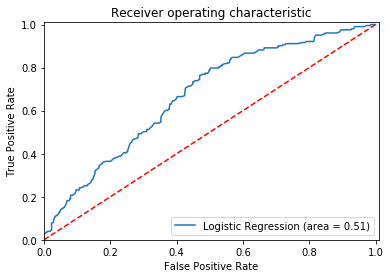

In [64]:
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")